# Getting LR Images from HR Source

This notebook created LR images of varying levels of blur and added noise from the HR sources.

In [ ]:
import astropy
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.convolution import Gaussian2DKernel, convolve
from astropy import units as u
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np 
import glob
import os
import matplotlib.pyplot as plt
import torch

import sys
# sys.path.append("/Users/peterli/Desktop/BS_thesis/code_main/Data Preparation")  # locally defined
from utils_custom import calc_psnr, calc_ssim, calc_sssim # modify utils to utils_custom to avoid conflict with Python package 'utils'


In [2]:
# HR -> LR methods

def normalize_image(image, max_val):
    image = np.clip(image, a_min=0.0, a_max=max_val)

    # Normalize the image
    image = image / max_val

    # Clip the final image in order to prevent rounding errors
    image = np.clip(image, a_min=0.0, a_max=1.0)

    return image

def add_psf(image, x_stddev=10):    
    psf = Gaussian2DKernel(x_stddev)
    psf_img = convolve(image, psf, boundary='wrap')
    return psf_img

# # 新增
# def add_psf_3D(image): # 对三维数组
#     """Apply Gaussian PSF separately to each channel of an RGB image."""
#     psf = Gaussian2DKernel(x_stddev=10)  # Define Gaussian blur kernel

#     # If grayscale (2D), apply PSF directly
#     if len(image.shape) == 2:
#         return convolve(image, psf, boundary='wrap')

#     # If RGB (3D), apply PSF to each channel separately
#     psf_img = np.zeros_like(image)
#     for c in range(image.shape[2]):  # Apply to each color channel
#         psf_img[..., c] = convolve(image[..., c], psf, boundary='wrap')

#     return psf_img

def add_noise(image, gaussian_scale=0.015, poisson_scale=0.015):
    gaussian_noise = gaussian_scale * np.random.normal(loc=0, scale=2, size=image.shape) #0.01
    poisson_noise = poisson_scale * np.random.poisson(image) #0.01
    return np.clip((image + gaussian_noise + poisson_noise), 0, 1)

# # 新增
# def add_noise_unnormal(image):
#     """Add Gaussian and Poisson noise to an RGB image."""
#     gaussian_noise = 0.015 * np.random.normal(loc=0, scale=2, size=image.shape)
#     poisson_noise = 0.015 * np.random.poisson(image)

#     noisy_image = image + gaussian_noise * 255 + poisson_noise * 255  # Scale noise properly
#     return np.clip(noisy_image, 0, 255).astype(np.uint8)  # Ensure valid pixel range

def crop_crop(imarray):
    # fixed height and width of cropped image, determined by min pixel height/width 
    # of images in our data set
    pixel_val = 256
    height = imarray.shape[0]
    width = imarray.shape[1]
    cropped_imarray = imarray[int(height//2-pixel_val/2):int(height//2+pixel_val/2), int(width//2-pixel_val/2):int(width//2+pixel_val/2)]
    if cropped_imarray.shape != (256, 256):
        print(cropped_imarray.shape)
    return cropped_imarray
    
    


In [ ]:
# # apply for all code below

# # 你的 HR 图像目录（FITS 文件存储位置）
# hr_dir = "/Users/peterli/Desktop/BS_thesis/nicmos_hr"
# # LR 图像保存目录
# lr_dir = "/Users/peterli/Desktop/BS_thesis/nicmos_lr"

# # 确保 LR 目录存在
# os.makedirs(lr_dir, exist_ok=True)

In [ ]:
# # generate lr images from hr images

# for filename in glob.glob(os.path.join(hr_dir, "*.fits")):
    
#     image_file = get_pkg_data_filename(filename)
#     imarray = fits.getdata(image_file, ext=0)
#     imarray = imarray.astype(np.float32)
    
#     img=imarray
    
#     max_val = np.max(imarray)
#     if max_val == 0:
#        continue
#     img = normalize_image(imarray, max_val)

#     img = add_psf(img)
#     img = add_noise(img)
    
#     # save lr image
#     filename_lr = os.path.join(lr_dir, 'lr_' + filename.split("/")[-1])
#     hdu = fits.PrimaryHDU(img)
#     hdu.writeto(filename_lr, overwrite=True)
        

In [ ]:
# # apply for .tiff images
# import glob
# import numpy as np
# from PIL import Image  # 用于读取 TIFF 图像
# import os

# # 定义 HR（高分辨率）和 LR（低分辨率）文件夹路径
# hr_dir = "/Users/peterli/Desktop/毕业设计/Hubble_Images"
# lr_dir = "/Users/peterli/Desktop/毕业设计/Hubble_LR_Images"

# # 确保 LR 目录存在
# os.makedirs(lr_dir, exist_ok=True)

# # 处理 HR 图像
# for filename in glob.glob(os.path.join(hr_dir, "HR_*.tif")):
#     # 获取文件名
#     base_filename = os.path.basename(filename)

#     # 读取 HR 图像
#     img = Image.open(filename).convert("RGB")  # 转换为 RGB 模式
#     img_array = np.array(img, dtype=np.float32)  # 转换为 NumPy 数组

#     # 处理图像
#     # img_array = add_psf(img_array)
#     # img_array = add_noise(img_array)
#     img_array = add_psf_3D(img_array)
#     img_array = add_noise_unnormal(img_array)

#     # 转换回 PIL 图像
#     lr_img = Image.fromarray(img_array)

#     # 保存 LR 图像
#     filename_lr = os.path.join(lr_dir, "LR_" + base_filename)
#     lr_img.save(filename_lr)

#     print(f"✅ 处理完成: {base_filename} → {filename_lr}")

# print("🎉 所有 LR 图像已成功生成！")


In [2]:
# # calculate ssim, psnr, sssim between hr and lr images
# ssim_vals = []
# sssim_vals = []
# psnr_vals = []

# ind = 0
# for filename in glob.glob(os.path.join(hr_dir, "*.fits")):
#     ind += 1
#     image_file_hr = get_pkg_data_filename(filename)
#     imarray_hr = fits.getdata(image_file_hr, ext=0)
#     imarray_hr = imarray_hr.astype(np.float32)
#     # filename_lr = lr_dir + filename.split("/")[-1]
#     filename_lr = os.path.join(lr_dir, 'lr_' + filename.split("/")[-1])

#     image_file_lr = get_pkg_data_filename(filename_lr)
#     imarray_lr = fits.getdata(image_file_lr, ext=0)
#     imarray_lr = imarray_lr.astype(np.float32)

#     img_1 = imarray_hr.reshape(1, imarray_hr.shape[0], imarray_hr.shape[1])
#     img_2 = imarray_lr.reshape(1, imarray_lr.shape[0], imarray_lr.shape[1])

#     sssim_vals.append(calc_sssim(torch.Tensor(img_1), torch.Tensor(img_2)))
#     ssim_vals.append(calc_ssim(torch.Tensor(img_1), torch.Tensor(img_2)))
#     psnr_vals.append(calc_psnr(torch.Tensor(img_1), torch.Tensor(img_2)))
    
#     print(ind)
    
# sssim_vals_df = pd.DataFrame(sssim_vals)
# ssim_vals_df = pd.DataFrame(ssim_vals)
# psnr_vals_df = pd.DataFrame(psnr_vals)

# sssim_vals_df.to_csv('sssim_results_lr_image_10_noise_0015.csv')
# ssim_vals_df.to_csv('ssim_results_lr_image_10_noise_0015.csv')
# psnr_vals_df.to_csv('psnr_results_lr_image_10_noise_0015.csv')

In [3]:
# plt.figure()
# plt.hist(ssim_vals, bins=10, alpha=0.5, color='purple', edgecolor='black', label='SSIM')
# plt.hist(sssim_vals, bins=20, alpha=0.5, color='limegreen', edgecolor='black', label='Selective SSIM')
# #plt.title("Histogram of SSIM and Selective SSIM index values ")
# plt.legend(fontsize=12)
# plt.xlabel('Score', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlim(xmin=0, xmax=1)
# plt.savefig("lr_images_ssim_results_10_noise_0015.png")

In [4]:
# plt.figure()
# plt.hist(psnr_vals, bins=6, alpha=0.5, color='purple', edgecolor='black', label='PSNR')
# #plt.title("Histogram of SSIM and Selective SSIM index values ")
# plt.legend(fontsize=12)
# plt.xlabel('Score', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlim(xmin=0)
# plt.savefig("lr_images_psnr_results_10_noise_0015.png")

In [5]:
# # print PSFs

# import matplotlib.pyplot as plt
# from astropy.convolution import Gaussian2DKernel

# psf_4 = Gaussian2DKernel(x_stddev=4)
# psf_7 = Gaussian2DKernel(x_stddev=7)
# psf_10 = Gaussian2DKernel(x_stddev=10)

# gaussian_2D_kernel = Gaussian2DKernel(x_stddev=10)
# plt.imshow(gaussian_2D_kernel, interpolation='none', origin='lower')
# plt.xlabel('x [pixels]', fontsize=12)
# plt.ylabel('y [pixels]', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.colorbar()
# plt.show()
# plt.savefig("psf_10.png")

In [6]:
# gaussian_2D_kernel = Gaussian2DKernel(x_stddev=4)
# plt.imshow(gaussian_2D_kernel, interpolation='none', origin='lower')
# plt.xlabel('x [pixels]', fontsize=12)
# plt.ylabel('y [pixels]', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.colorbar()
# plt.show()
# plt.savefig("psf_4.png")

In [7]:
# gaussian_2D_kernel = Gaussian2DKernel(x_stddev=7)
# plt.imshow(gaussian_2D_kernel, interpolation='none', origin='lower')
# plt.xlabel('x [pixels]', fontsize=12)
# plt.ylabel('y [pixels]', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.colorbar()
# plt.show()
# plt.savefig("psf_7.png")

## Get Selective HR and LR Images

In [42]:
# 唯一修改处：
change = '4_001' # choose between 4_001, 10_001, 10_0015



se_hr_dir = "../../nicmos_se_hr_"+change
se_lr_dir = "../../nicmos_se_lr_"+change
os.makedirs(se_hr_dir, exist_ok=True)
os.makedirs(se_lr_dir, exist_ok=True)

In [11]:
# generate selective hr and lr images from hr images
for filename in glob.glob(os.path.join(hr_dir, "*.fits")):
    
    image_file = get_pkg_data_filename(filename)
    imarray = fits.getdata(image_file, ext=0)
    imarray = imarray.astype(np.float32)
    
    img=imarray

    max_val = np.max(imarray)
    if max_val == 0:
        continue
    img = normalize_image(imarray, max_val)
    
    data = img.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=23) # use clustering method with k=3
    kmeans.fit(data)
    if len(np.unique(kmeans.labels_)) == 1:
        continue
        
    # apply operations to image
    img = crop_crop(img)
    if img.shape != (256,256):
        continue
    



    # """
    # FILL!!!!!!!!!!!!!!!!!!!!!
    # """
    psf_img = add_psf(image=img, x_stddev=4)
    lr_img = add_noise(image=psf_img, gaussian_scale=0.01, poisson_scale=0.01)
    




    # define selective hr image
    data = img.flatten()
    data = data.reshape(-1,1)
    # print("data shape:", data.shape) ###
    # print("imarray.flatten() shape:", imarray.flatten().shape) ###
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
    kmeans.fit(data)
    
    # df = pd.DataFrame({'brightness': imarray.flatten(), ###
    #                     'label': kmeans.labels_})
    df = pd.DataFrame({'brightness': img.flatten(), ###
                        'label': kmeans.labels_})
        
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(img.shape)
    labels = kmeans.labels_.reshape(img.shape[0],img.shape[1])
    background_array = 1 * (labels == background_label)
    detailed_array = 1*(labels != background_label)
    img = detailed_array * img

    # save hr image
    filename_hr = os.path.join(se_hr_dir, 'se_' + filename.split("/")[-1])
    hdu = fits.PrimaryHDU(img)
    hdu.writeto(filename_hr, overwrite=True)
    
    # define selective lr image
    data = lr_img.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
    kmeans.fit(data)
    
    # df = pd.DataFrame({'brightness': imarray.flatten(),
    #                     'label': kmeans.labels_})
    df = pd.DataFrame({'brightness': img.flatten(),
                        'label': kmeans.labels_})
        
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(lr_img.shape)
    labels = kmeans.labels_.reshape(lr_img.shape[0],lr_img.shape[1])
    background_array = 1 * (labels == background_label)
    detailed_array = 1*(labels != background_label)
    lr_img = detailed_array * lr_img 
    
    # save lr image
    filename_lr = os.path.join(se_lr_dir, 'lr_se_' + filename.split("/")[-1])
    hdu = fits.PrimaryHDU(lr_img)
    hdu.writeto(filename_lr, overwrite=True)

        

In [43]:
# calculate ssim, psnr, sssim between selective hr and lr images
ssim_vals = []
sssim_vals = []
psnr_vals = []

ind = 0
for filename in glob.glob(os.path.join(se_hr_dir, "*.fits")):
    ind += 1
    image_file_hr = get_pkg_data_filename(filename)
    imarray_hr = fits.getdata(image_file_hr, ext=0)
    imarray_hr = imarray_hr.astype(np.float32)

    filename_lr = os.path.join(se_lr_dir, 'lr_' + filename.split("/")[-1])
    image_file_lr = get_pkg_data_filename(filename_lr)
    imarray_lr = fits.getdata(image_file_lr, ext=0)
    imarray_lr = imarray_lr.astype(np.float32)

    img_1 = imarray_hr.reshape(1, imarray_hr.shape[0], imarray_hr.shape[1])
    img_2 = imarray_lr.reshape(1, imarray_lr.shape[0], imarray_lr.shape[1])

    sssim_vals.append(calc_sssim(torch.Tensor(img_1), torch.Tensor(img_2)).item())
    ssim_vals.append(calc_ssim(torch.Tensor(img_1), torch.Tensor(img_2)).item())
    psnr_vals.append(calc_psnr(torch.Tensor(img_1), torch.Tensor(img_2)).item())
    
    print(ind)
    
sssim_vals_df = pd.DataFrame(sssim_vals)
ssim_vals_df = pd.DataFrame(ssim_vals)
psnr_vals_df = pd.DataFrame(psnr_vals)

sssim_vals_df.to_csv('result_data/sssim_se_'+change+'.csv')
ssim_vals_df.to_csv('result_data/ssim_se_'+change+'.csv')
psnr_vals_df.to_csv('result_data/psnr_se_'+change+'.csv')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [16]:
# plt.figure()
# plt.hist(ssim_vals, bins=18, alpha=0.5, color='purple', edgecolor='black', label='SSIM')
# plt.hist(sssim_vals, bins=17, alpha=0.5, color='limegreen', edgecolor='black', label='Selective SSIM')
# plt.title("selective [HR] & [LR] in preparation with change "+change)
# plt.legend(fontsize=12)
# plt.xlabel('Score', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlim(xmin=0, xmax=1)
# plt.savefig('result_plot/sssim_se_'+change+'.png')

In [47]:
# ssim_vals

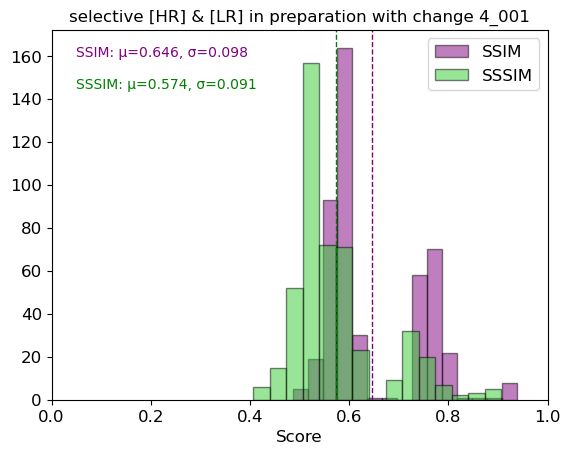

In [45]:
# 计算统计量
ssim_mean = np.mean(ssim_vals)
ssim_std = np.std(ssim_vals)
sssim_mean = np.mean(sssim_vals)
sssim_std = np.std(sssim_vals)

plt.figure()
plt.hist(ssim_vals, bins=15, alpha=0.5, color='purple', edgecolor='black', label='SSIM')
plt.hist(sssim_vals, bins=15, alpha=0.5, color='limegreen', edgecolor='black', label='SSSIM')

# 添加均值、方差文本
plt.text(0.05, 160, f'SSIM: μ={ssim_mean:.3f}, σ={ssim_std:.3f}', fontsize=10, color='purple')
plt.text(0.05, 145, f'SSSIM: μ={sssim_mean:.3f}, σ={sssim_std:.3f}', fontsize=10, color='green')

# 可选：标出均值所在位置的竖线
plt.axvline(ssim_mean, color='purple', linestyle='dashed', linewidth=1)
plt.axvline(sssim_mean, color='green', linestyle='dashed', linewidth=1)

plt.legend(fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(xmin=0, xmax=1)
plt.title("selective [HR] & [LR] in preparation with change "+change)
plt.savefig('result_plot/ssim_se_'+change+'.png')


In [ ]:
# plt.figure()
# plt.hist(psnr_vals, bins=10, alpha=0.5, color='purple', edgecolor='black', label='PSNR')
# #plt.title("Histogram of SSIM and Selective SSIM index values ")
# plt.legend(fontsize=12)
# plt.xlabel('Score', fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlim(xmin=0)
# plt.savefig("psnr_se_4_001.png")